# Internship Assignment by Alan Nessipbayev

## Download libraries and datasets

In [3]:
import re
import json
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')
# load datasets
training_set = "data/tweet_sentiment.train.jsonl"
test_set = "data/tweet_sentiment.test.jsonl"

# load gloVe data and assign in form (word -> vector)
embeddings = {}
with open("glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vectors = list(map(float, parts[1:]))
        embeddings[word] = vectors

stop_words = stopwords.words('english')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Prepare data

In [5]:
# extract data
def extract_data(filepath):
    X_features = []
    y_labels = []
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            X_features.append(data['text'])
            y_labels.append(data['label'])
            
    return X_features, y_labels

# data preprocessing
def preprocess(tweets):
    x_preprocessed = []
    for tweet in tweets:
        cleaned_tokens = []
        tweet = re.sub(r"https?://\S+|www\.\S+|@\S+", "", tweet.lower())
        tokens = word_tokenize(tweet)
        for token in tokens:
            if token not in stop_words and token.isalpha():
                cleaned_tokens.append(token)
        x_preprocessed.append(cleaned_tokens)
    return x_preprocessed
    
# data vectorization
def vectorize(tweets):
    x_vectorized = []
    for tweet in tweets:
        vectors_per_tweet = []
        for token in tweet:
            if token in embeddings:
                vectors_per_tweet.append(embeddings[token])
        if vectors_per_tweet:
            tweet_vector = np.mean(vectors_per_tweet, axis=0)
        else:
            tweet_vector = np.zeros(100)
        x_vectorized.append(tweet_vector)

    return np.stack(x_vectorized)


# put data preparation steps in a pipeline (I decided to use a pipeline for modularization of the code)
pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess, validate=False)),
    ('vectorize', FunctionTransformer(vectorize, validate=False))
])

### Load data and initialize models

In [7]:
# extract training and testing datasets
x_train, y_train = extract_data(training_set)
x_test, y_test = extract_data(test_set)

# run tweets through the preprocessing pipeline
x_train_prep = pipeline.fit_transform(x_train)
x_test_prep = pipeline.fit_transform(x_test)

# hyperparameters grid (I decided to put the most common numbers and for solver I just copy-pasted it from sklearn documentation)
parameters = {
    'C': [0.01, 0.1, 1, 5, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'max_iter': [300, 1000],
}


# initialize testing models
log_reg = LogisticRegression()
gaus = GaussianNB()

# input model into the hyperparameter tuner
random_search = RandomizedSearchCV(
    log_reg,
    param_distributions = parameters,
    n_iter = 20, 
    scoring ='f1_macro',
    cv = 5,
    random_state = 42
)





### Plot data

Counter({'negative': 7343, 'neutral': 2479, 'positive': 1890})


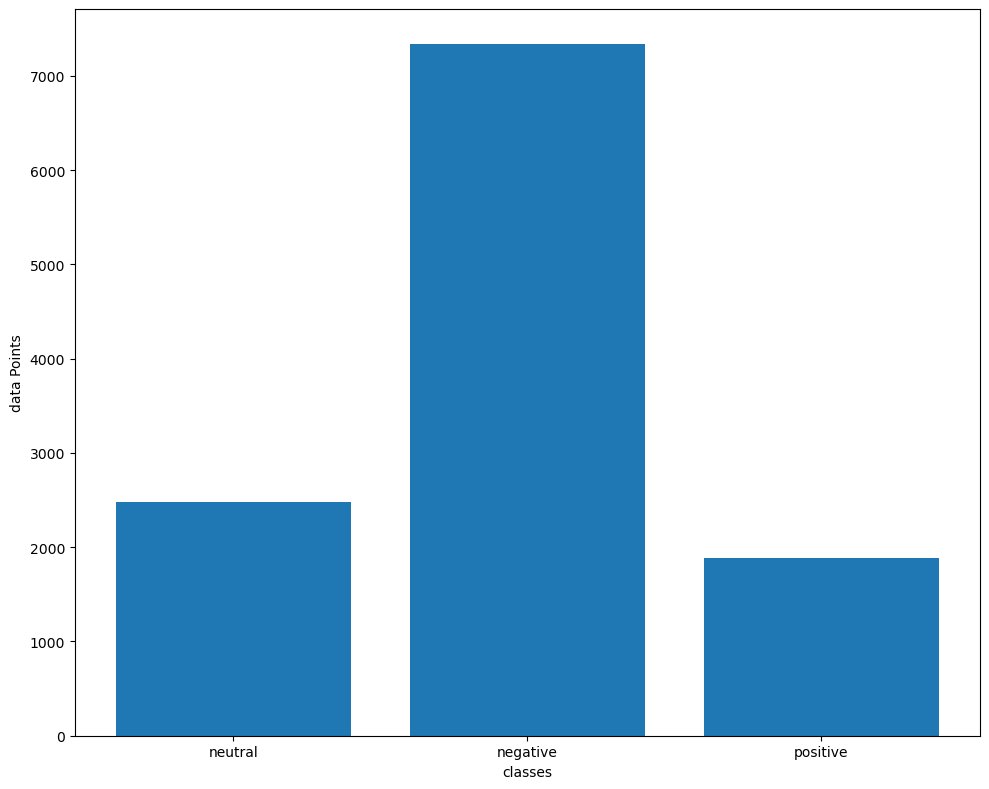

In [9]:
# check how many datapoints in each class
label_counts = Counter(y_train)
print(label_counts)

# create axes
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# create bar chart
plt.figure(figsize=(10, 8))
plt.bar(label_names, label_values)
plt.xlabel('classes')
plt.ylabel('data Points')
plt.tight_layout()
plt.show()

As you can see there is a significant imbalance in the training set. Such an imbalance will significantly affect the classification of the tweets, especially given that all classes are equally important. It is something that I try to address further in the notebook.

### Balance and Plot new Dataset

Counter({'neutral': 7343, 'negative': 7343, 'positive': 7343})


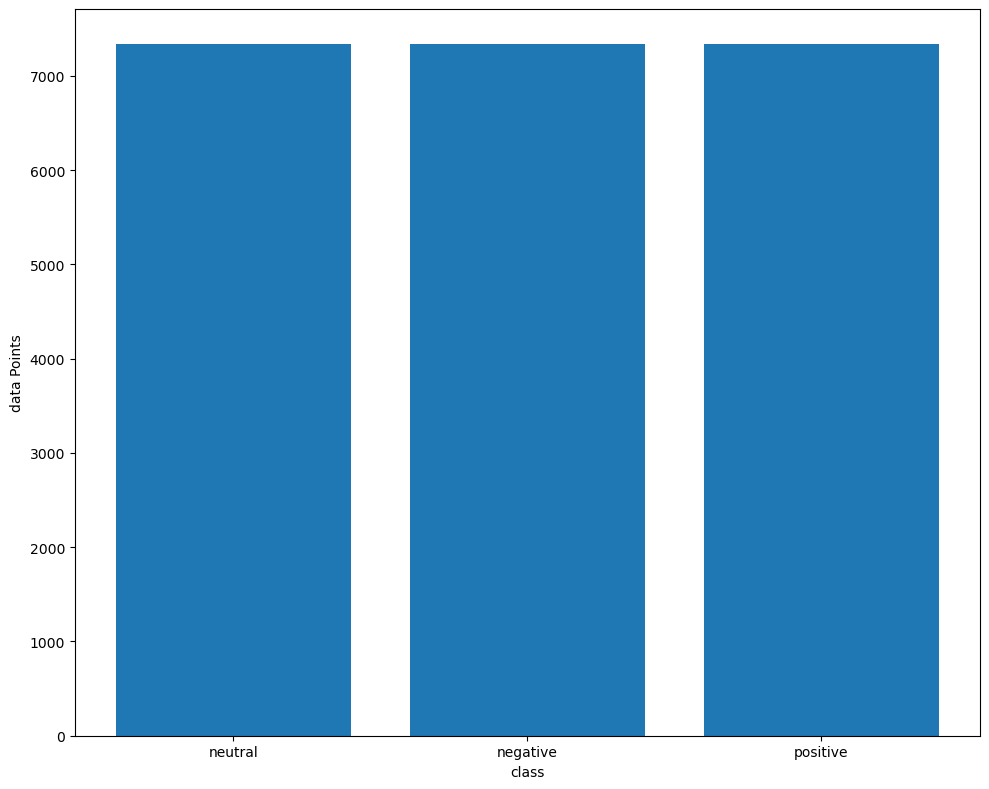

In [12]:
# initialize SMOTE (used for dataset balancing)
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(x_train_prep, y_train)

# check how many datapoints in each class
label_counts = Counter(y_train_balanced)
print(label_counts)

# separate keys and values for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# create bar chart
plt.figure(figsize=(10, 8))
plt.bar(label_names, label_values)
plt.xlabel('class')
plt.ylabel('data Points')
plt.tight_layout()
plt.show()



## Train, predict and evaluate for imbalanced data

In [14]:
# train model
def train_model(model, X_train_data, y_train_data):
    model.fit(X_train_data, y_train_data)
    
# make prediction
def predict(model, X_test_data):
    prediction = model.predict(X_test_data)
    return prediction

# show results
def evaluate(true_data, pred_data):
    print(classification_report(true_data, pred_data))

In [15]:
# find best parameters for logistic regression
train_model(random_search, x_train_prep, y_train)
best_params = random_search.best_params_

# train and predict for llogistic regression model
log_reg = LogisticRegression(**best_params)
train_model(log_reg, x_train_prep, y_train)
prediction = predict(log_reg, x_test_prep)
print("Evaluation for logistic regression model with imbalanced data:")
evaluate(y_test, prediction)

print("-----------------------------------------")

# train and predict for gaussianNB model
train_model(gaus, x_train_prep, y_train)
prediction2 = predict(gaus, x_test_prep)
print("Evaluation for logistic gaussianNB model with balanced data:")
evaluate(y_test, prediction2)


Evaluation for logistic regression model with imbalanced data:
              precision    recall  f1-score   support

    negative       0.82      0.83      0.83      1835
     neutral       0.53      0.50      0.51       620
    positive       0.66      0.67      0.67       473

    accuracy                           0.74      2928
   macro avg       0.67      0.67      0.67      2928
weighted avg       0.73      0.74      0.73      2928

-----------------------------------------
Evaluation for logistic gaussianNB model with balanced data:
              precision    recall  f1-score   support

    negative       0.75      0.83      0.79      1835
     neutral       0.46      0.45      0.46       620
    positive       0.59      0.39      0.47       473

    accuracy                           0.68      2928
   macro avg       0.60      0.55      0.57      2928
weighted avg       0.66      0.68      0.67      2928



## Represent confusion matrices for imbalanced data

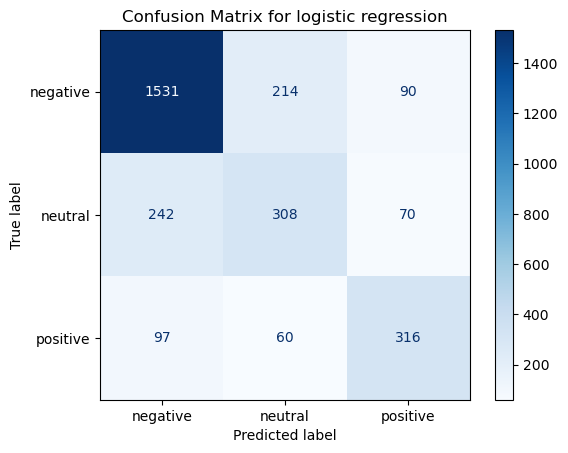

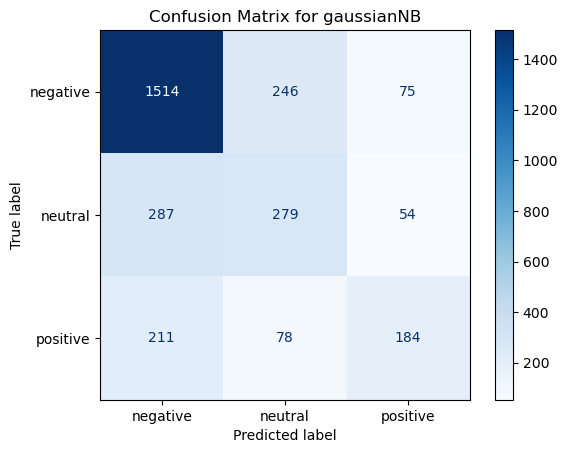

In [17]:
# show confusion matrix for logistic regression
cm = confusion_matrix(y_test, prediction, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for logistic regression")
plt.show()

# show confusion matrix for gaussianNB
cm = confusion_matrix(y_test, prediction2, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for gaussianNB")
plt.show()

Interesting misclassifications of the logistic regression model:

1) A lot negative datapoints are being misclassified as neutral labels. It can be caused by the lack of "positive" words within the tweets as well as the imbalanced training dataset.
2) Similarly to the first point, many neutral datapoints are misclassified as negative labels. I assume it has the same reasons as I mentioned previously.
3) Lastly, interestingly, in case of misclassifications the model marks positive classes as "negative" ~ 1.6x times more than "neutral".

## Train, predict and evaluate for balanced data

In [20]:
# find best parameters for logistic regression
train_model(random_search, X_train_balanced, y_train_balanced)
best_params = random_search.best_params_

# train and predict for logistic regression model with balanced data
log_reg = LogisticRegression(**best_params)
train_model(log_reg, X_train_balanced, y_train_balanced)
prediction = predict(log_reg, x_test_prep)
print("Evaluation for logistic regression model with balanced data:")
evaluate(y_test, prediction)

print("-----------------------------------------")

# train and predict for gaussianNB model with balanced data
train_model(gaus, X_train_balanced, y_train_balanced)
prediction2 = predict(gaus, x_test_prep)
print("Evaluation for logistic gaussianNB model with balanced data:")
evaluate(y_test, prediction2)

Evaluation for logistic regression model with balanced data:
              precision    recall  f1-score   support

    negative       0.86      0.69      0.77      1835
     neutral       0.44      0.61      0.51       620
    positive       0.58      0.71      0.64       473

    accuracy                           0.68      2928
   macro avg       0.63      0.67      0.64      2928
weighted avg       0.72      0.68      0.69      2928

-----------------------------------------
Evaluation for logistic gaussianNB model with balanced data:
              precision    recall  f1-score   support

    negative       0.80      0.76      0.78      1835
     neutral       0.44      0.54      0.48       620
    positive       0.56      0.50      0.53       473

    accuracy                           0.67      2928
   macro avg       0.60      0.60      0.60      2928
weighted avg       0.68      0.67      0.68      2928



## Represent confusion matrices for balanced data

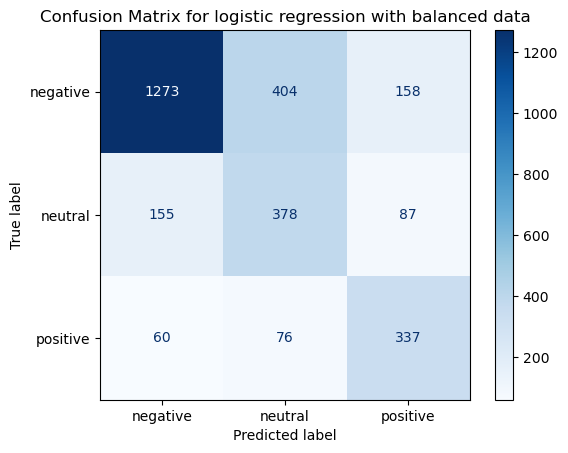

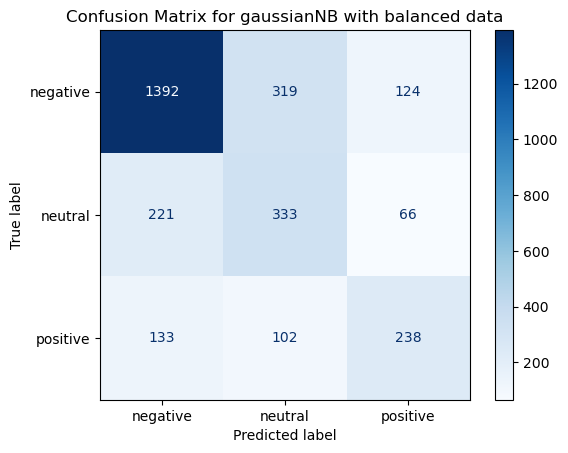

In [22]:
# compute confusion matrix for logistic regression with balanced data
cm = confusion_matrix(y_test, prediction, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for logistic regression with balanced data")
plt.show()

# compute confusion matrix for gaussianNB with balanced data
cm = confusion_matrix(y_test, prediction2, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for gaussianNB with balanced data")
plt.show()

## Experiment with synonym replacement using logistic regression

To be honest this section is not something I have done before, so it might be a bit messy. However, I have tried to do it the best I can.

In [24]:
# returns a synonym or None if a synonym is not found
def find_synonym(word):
    synonyms = wn.synsets(word)
    if not synonyms:
        return None

    for synonym in synonyms:
        for lemma in synonym.lemmas():
            synonym_candidate = lemma.name().replace("_", " ").lower()
            if synonym_candidate != word:
                return synonym_candidate

    return None

# data vectorization
def experiment_vectorize(tweets):
    x_vectorized = []
    for tweet in tweets:
        vectors_per_tweet = []
        for token in tweet:
            if token in embeddings:
                vectors_per_tweet.append(embeddings[token])
            else:
                synonym = find_synonym(token)
                if synonym and synonym in embeddings:
                    vectors_per_tweet.append(embeddings[synonym])
        if vectors_per_tweet:
            tweet_vector = np.mean(vectors_per_tweet, axis=0)
        else:
            tweet_vector = np.zeros(100)
        x_vectorized.append(tweet_vector)

    return np.stack(x_vectorized)

# new pipeline for the experiment
new_pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess, validate=False)),
    ('experiment_vectorize', FunctionTransformer(experiment_vectorize, validate=False))
])

### Preprocessing, training, and results with synonym replacement

In [26]:
# receive augmented datasets
x_train_prep_experiment = new_pipeline.fit_transform(x_train)
x_test_prep_experiment = new_pipeline.fit_transform(x_test)

# find best parameters for logistic regression
train_model(random_search, x_train_prep_experiment, y_train)
best_params = random_search.best_params_

# train and predict for logistic regression model
log_reg = LogisticRegression(**best_params)
train_model(log_reg, x_train_prep_experiment, y_train)
prediction = predict(log_reg, x_test_prep_experiment)
print("Evaluation for logistic regression model with augmented data:")
evaluate(y_test, prediction)

Evaluation for logistic regression model with augmented data:
              precision    recall  f1-score   support

    negative       0.82      0.83      0.83      1835
     neutral       0.53      0.50      0.51       620
    positive       0.66      0.67      0.67       473

    accuracy                           0.73      2928
   macro avg       0.67      0.67      0.67      2928
weighted avg       0.73      0.73      0.73      2928



## Confusion matrix the experiment

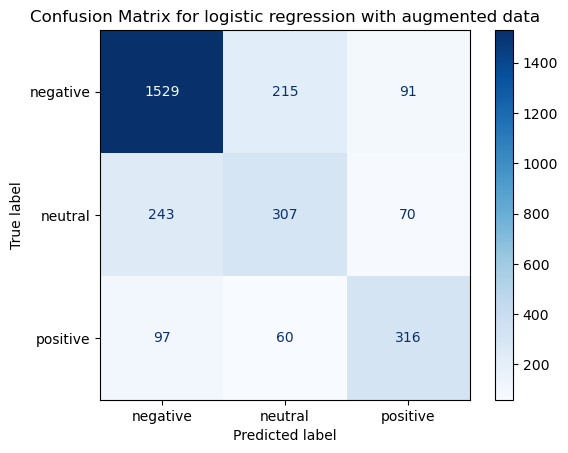

In [28]:
# compute confusion matrix for logistic regression with augmented data
cm = confusion_matrix(y_test, prediction, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for logistic regression with augmented data")
plt.show()

## Reflection

It seems like most of the things worked well and the results are somewhat acceptable. Glove embddings seem to be quite helpful with vectorization of words, the models I used seem to be feasible and the preprocessing steps seem to be somewhat enough. Due to the fact that both the training and testing datasets are heavily imbalanced I tried to balance them with SMOTE and the prediction rates for two minority classes(positive and neutral) went up slightly. However, it came as a trade-off to the correct prediction rates of the negative class, which is reasonable. Therefore, I would like to count it as a success because the cases of correct classification of minority classes, especially for logistic regression, improved significantly. Overall, everything seems to work fine and the results are acceptable. Lastly, I attempted the synonym replacement but as the result the accuracy went 1% down, so, perhaps, it does not give much or mine implementation is not sufficient/ideal. 

One thing that I would like to propose would be a proper data balancing step. Even though I have tried to implement it as a step already, the results are clearly not as ideal as they could be. Therefore, a supervised resampling could be a good idea. As a suggestion, it could be a good approach to lower the number of datapoints for negative class (might be a bad idea of course as less points usually means worse) to put it in the same size ration as two other classes.

Note: The runtime might be a bit affected by the fact that I added an extra step with dataset balancing and hyperparameter search.